# I. Environment setup

NumPy, Pandas → Data handling

Matplotlib, Seaborn → Visualization

SciPy → Signal processing

Scikit-learn → Machine learning

TensorFlow, PyTorch → Deep learning

WFDB → Handling PhysioNet data

h5py → Loading .mat files

Neurokit2 → ECG preprocessing

In [ ]:
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# II. Data Exploration

See the file "ECG_Exploration.ipynb"

# III. Pre processing

In [ ]:
data_path= r'C:\Users\julie\Documents\Healthcare\Project\full_ecg_with_answers.csv'

In [ ]:
df = pd.read_csv(data_path)

In [ ]:
df.head()

,File_ID,Num_Leads,Sampling_Rate,Num_Samples,Gain,Offset,Signal_Type,ECG_Signal,Label
0,A08031,1,300,18000,1000.0,254,ECG,"[254, 259, 264, 245, 215, 181, 152, 133, 152, ...",N
1,A08033,1,300,9000,1000.0,216,ECG,"[216, 264, 315, 369, 402, 414, 421, 424, 424, ...",N
2,A08035,1,300,9000,1000.0,-403,ECG,"[-403, -510, -603, -683, -754, -803, -819, -82...",~
3,A08032,1,300,9000,1000.0,-230,ECG,"[-230, -282, -336, -396, -419, -426, -429, -43...",N
4,A08029,1,300,9000,1000.0,908,ECG,"[908, 1130, 1371, 1618, 1842, 2025, 2098, 2146...",N


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528 entries, 0 to 8527
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   File_ID        8528 non-null   object 
 1   Num_Leads      8528 non-null   int64  
 2   Sampling_Rate  8528 non-null   int64  
 3   Num_Samples    8528 non-null   int64  
 4   Gain           8528 non-null   float64
 5   Offset         8528 non-null   int64  
 6   Signal_Type    8528 non-null   object 
 7   ECG_Signal     8528 non-null   object 
 8   Label          8528 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 599.8+ KB


In [ ]:
print(df['ECG_Signal'].dtype)
print(type(df['ECG_Signal'].iloc[0]))  # Check the type of the first value

object
<class 'str'>


ECG signal is in object format. Let's change this into s

In [ ]:
# Convert ECG_Signal column from string to list
df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: np.array(eval(x)))

In [ ]:
print(df['ECG_Signal'].dtype)
print(type(df['ECG_Signal'].iloc[0]))

object
<class 'numpy.ndarray'>


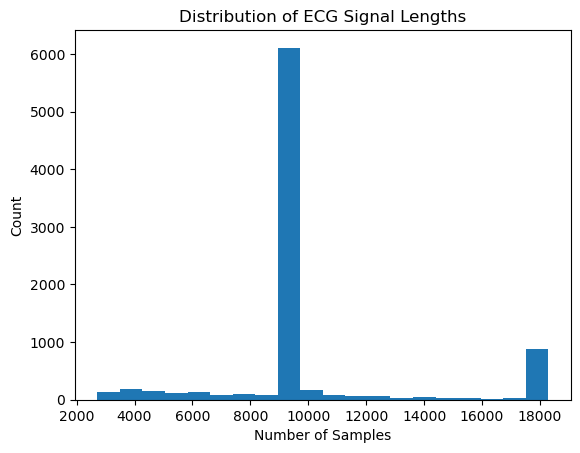

In [ ]:
# Check signal length distribution
def check_signal_length(df):
    lengths = df['ECG_Signal'].apply(len)
    plt.hist(lengths, bins=20)
    plt.xlabel("Number of Samples")
    plt.ylabel("Count")
    plt.title("Distribution of ECG Signal Lengths")
    plt.show()
    return lengths

lengths = check_signal_length(df)
fixed_length = int(np.median(lengths))  # Choosing median length as standard

In [ ]:
# Padding or Truncating Signals
def pad_or_truncate(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')
    return signal

df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: pad_or_truncate(x, 9000))

In [ ]:
print(df['ECG_Signal'].apply(len).unique())  # [9000]

[9000]


### 1. Normalize ECG signals (0 mean, unit variance)

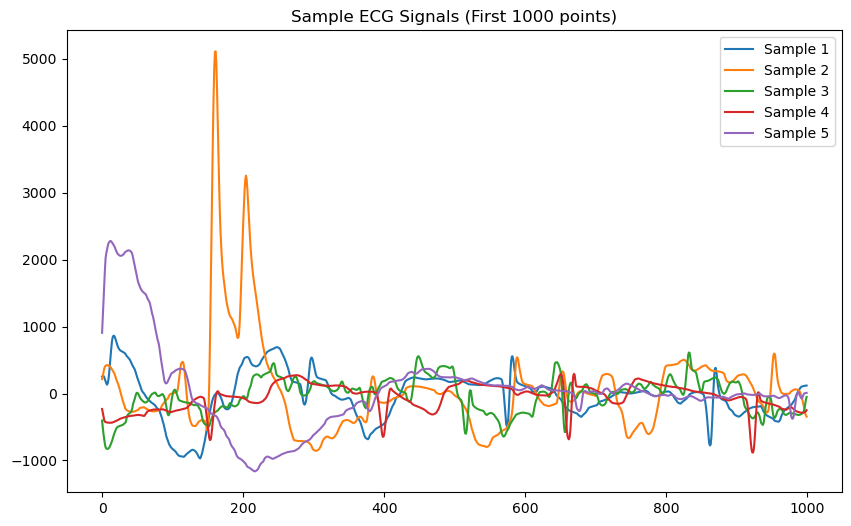

In [ ]:
# Visualize some ECG signals
def plot_ecg_samples(df, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(df['ECG_Signal'].iloc[i][:1000], label=f"Sample {i+1}")
    plt.legend()
    plt.title("Sample ECG Signals (First 1000 points)")
    plt.show()

plot_ecg_samples(df)

In [ ]:
# Normalization
def normalize_signals(df, method='z-score'):
    all_signals = np.vstack(df['ECG_Signal'].values)
    if method == 'z-score':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    normalized_signals = scaler.fit_transform(all_signals)
    df['ECG_Signal'] = list(normalized_signals)
    print("Shape after Normalization :", all_signals.shape)  # Devrait être (N, 9000) mais peut être (N, <9000)
    return df

df = normalize_signals(df)

Shape after Normalization : (8528, 9000)


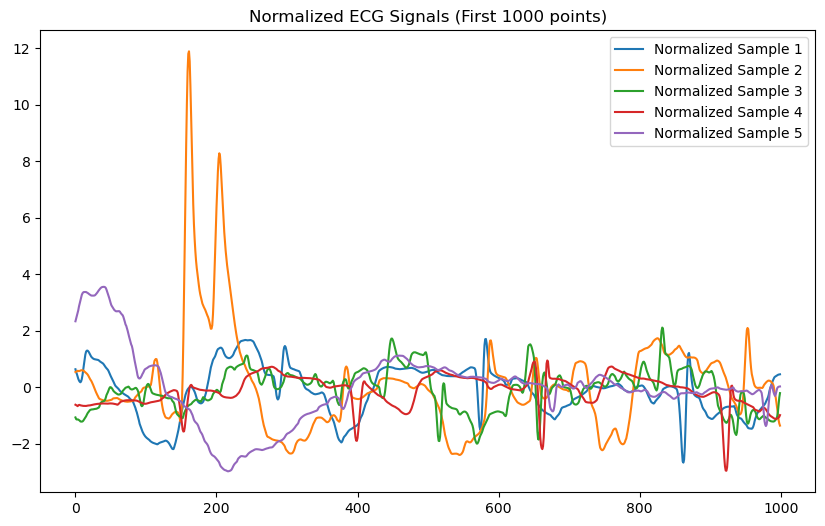

In [ ]:
# Visualize effect of normalization
def plot_normalized_signals(df, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(df['ECG_Signal'].iloc[i][:1000], label=f"Normalized Sample {i+1}")
    plt.legend()
    plt.title("Normalized ECG Signals (First 1000 points)")
    plt.show()

plot_normalized_signals(df)

In [ ]:
# Bandpass Filter (0.5 - 40 Hz)
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(signal, fs=300, lowcut=0.5, highcut=40.0, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, signal)

df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: apply_bandpass_filter(x))

print("Legth after filter :", df['ECG_Signal'].apply(len).unique())  # Vérifie si la longueur change

Legth after filter : [9000]


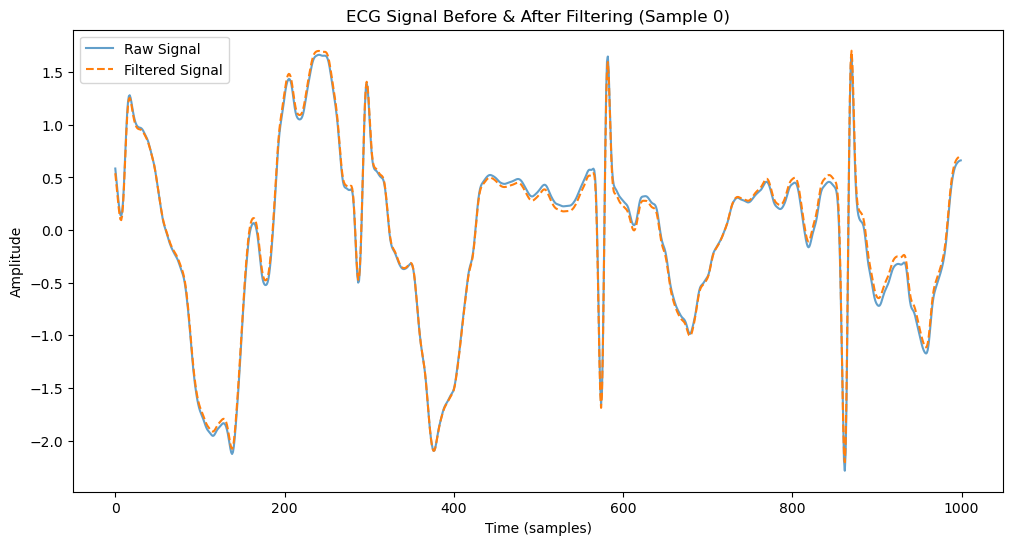

In [ ]:
def plot_before_after_filtering(df, sample_idx=0):
    raw_signal = df['ECG_Signal'].iloc[sample_idx]  # Get raw ECG
    filtered_signal = apply_bandpass_filter(raw_signal)  # Apply bandpass filter

    plt.figure(figsize=(12, 6))
    plt.plot(raw_signal[:1000], label="Raw Signal", alpha=0.7)
    plt.plot(filtered_signal[:1000], label="Filtered Signal", linestyle="dashed")
    plt.legend()
    plt.title(f"ECG Signal Before & After Filtering (Sample {sample_idx})")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

# Call the function for visualization
plot_before_after_filtering(df, sample_idx=0)  # Change index for other samples

In [ ]:
# Class Imbalance Handling (if labels available)
if 'Label' in df.columns:
    class_counts = df['Label'].value_counts()
    print("Class Distribution:\n", class_counts)
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(np.vstack(df['ECG_Signal']), df['Label'])
    df_resampled = pd.DataFrame({'ECG_Signal': list(X_resampled), 'Label': y_resampled})
    df = df_resampled

Class Distribution:
 Label
N    5154
O    2557
A     771
~      46
Name: count, dtype: int64


# IV. Feature extraction

- statistical features : mean, variance, skewness, kurtosis
- frequency domain features : power spectral density (FFT)
- heart rate variability (HRV) features

In [ ]:
print(df['ECG_Signal'].apply(len).unique())  # [9000]

[9000]


In [ ]:
def segment_ecg(signal, segment_length=1500, overlap=1200, fs=300):
    """
    Split the ECG signal into fixed-size overlapping windows.
    segment_length: number of samples (5s * 300Hz = 1500 samples)
    overlap: number of overlapping samples (4s * 300Hz = 1200 samples)
    """
    segments = []
    step = segment_length - overlap
    for start in range(0, len(signal) - segment_length + 1, step):
        segments.append(signal[start:start + segment_length])
    return segments


df['ECG_Signal'] = df['ECG_Signal'].apply(lambda x: segment_ecg(x))


In [ ]:
df.head()

,ECG_Signal,Label
0,"[[0.5841855407472221, 0.49943404633485383, 0.4...",N
1,"[[-0.4788607897488064, -0.4654993553723988, -0...",N
2,"[[-0.17686516800919921, -0.2134701637860065, -...",~
3,"[[-0.06745055794617015, -0.08572080047144767, ...",N
4,"[[1.0608547088952154, 1.1619429224953348, 1.26...",N


In [ ]:
df = df.explode('ECG_Signal', ignore_index=True)


In [ ]:
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, welch
from scipy.stats import entropy
from pywt import wavedec
from numpy.linalg import eigvals

def extract_features(ecg_signal, fs=300):
    """
    Extract statistical, frequency domain, and HRV features from an ECG signal.

    Parameters:
    ecg_signal (numpy array): 1D array of ECG signal
    fs (int): Sampling frequency of the ECG signal (default: 300 Hz)

    Returns:
    dict: Extracted features
    """

    #NEW ideas from papers
    # 1. Additional temporal caracteristics
    p_amplitude = np.max(ecg_signal) - np.min(ecg_signal)  # Amplitude max
    energy = np.sum(ecg_signal**2)  # Énergie du signal

    # 2. Entropy (Shannon, Rényi, Tsallis)
    hist, _ = np.histogram(ecg_signal, bins=50, density=True)
    shannon_entropy = entropy(hist)
    renyi_entropy = np.log(np.sum(hist**2))
    tsallis_entropy = (1 - np.sum(hist**3)) / (1 - 2)

    # 3. Wavelets analyse
    coeffs = wavedec(ecg_signal, 'db4', level=4)  # Decomposition Daubechies 4 levels
    wavelet_energy = sum(np.sum(np.array(c)**2) for c in coeffs)

    # 4. No linear analyse
    covariance_matrix = np.cov(ecg_signal[:-1], ecg_signal[1:])
    eigenvalues = eigvals(covariance_matrix)
    largest_eigenvalue = np.max(eigenvalues)





    # 1. **Statistical Features**
    mean_val = np.mean(ecg_signal)
    variance_val = np.var(ecg_signal)
    skewness_val = skew(ecg_signal)
    kurtosis_val = kurtosis(ecg_signal)

    # 2. **Frequency Domain Features (Power Spectral Density using FFT)**
    freqs, psd = welch(ecg_signal, fs, nperseg=1024)  # Power spectral density
    total_power = np.sum(psd)
    dominant_freq = freqs[np.argmax(psd)]  # Frequency with max power

    # 3. **Heart Rate Variability (HRV) Features**
    peaks, _ = find_peaks(ecg_signal, height=np.mean(ecg_signal) + np.std(ecg_signal))  # Detect R-peaks
    rr_intervals = np.diff(peaks) / fs  # Compute RR intervals (in seconds)

    if len(rr_intervals) > 0:
        mean_rr = np.mean(rr_intervals)
        std_rr = np.std(rr_intervals)
    else:
        mean_rr = std_rr = 0  # Default values if no peaks found



    # Return features as a dictionary
    features = {
        "mean": mean_val,
        "variance": variance_val,
        "skewness": skewness_val,
        "kurtosis": kurtosis_val,
        "total_power": total_power,
        "dominant_freq": dominant_freq,
        "mean_rr": mean_rr,
        "std_rr": std_rr,
        "p_amplitude": p_amplitude,
        "energy": energy,
        "shannon_entropy": shannon_entropy,
        "renyi_entropy": renyi_entropy,
        "tsallis_entropy": tsallis_entropy,
        "wavelet_energy": wavelet_energy,
        "largest_eigenvalue": largest_eigenvalue
    }

    return features



In [ ]:
# Apply feature extraction to the entire dataset
feature_list = df['ECG_Signal'].apply(lambda x: extract_features(np.array(x)))

# Convert extracted features into a DataFrame
df_features = pd.DataFrame(feature_list.tolist())

# Display extracted features
display(df_features.head())
print(df_features.head())

,mean,variance,skewness,kurtosis,total_power,dominant_freq,mean_rr,std_rr,p_amplitude,energy,shannon_entropy,renyi_entropy,tsallis_entropy,wavelet_energy,largest_eigenvalue
0,-0.028520,0.777390,-0.735147,0.511845,1.862516,1.171875,0.484074,0.401813,5.116034,1167.305305,3.405517,1.423505,1.546803,1182.713259,1.551402
1,-0.015768,0.594881,-1.019957,1.637275,1.147914,1.171875,0.480417,0.428743,5.345866,892.693854,3.246570,1.519577,2.096977,956.492389,1.184004
2,0.008659,0.528408,-0.887102,2.546563,2.561137,1.171875,0.480833,0.429210,6.128280,792.723800,3.082785,1.367623,1.378781,801.684468,1.051031
3,0.004715,0.565156,-0.541794,2.148743,2.772072,0.878906,0.349091,0.382781,6.128280,847.768093,3.112752,1.321165,1.084111,889.904404,1.124291
4,0.022208,0.480831,-0.451234,3.551165,1.468496,0.878906,0.389722,0.390476,6.128280,721.985939,3.010006,1.434415,1.624260,817.628258,0.954033


       mean  variance  skewness  kurtosis  total_power  dominant_freq  \
0 -0.028520  0.777390 -0.735147  0.511845     1.862516       1.171875   
1 -0.015768  0.594881 -1.019957  1.637275     1.147914       1.171875   
2  0.008659  0.528408 -0.887102  2.546563     2.561137       1.171875   
3  0.004715  0.565156 -0.541794  2.148743     2.772072       0.878906   
4  0.022208  0.480831 -0.451234  3.551165     1.468496       0.878906   

    mean_rr    std_rr  p_amplitude       energy  shannon_entropy  \
0  0.484074  0.401813     5.116034  1167.305305         3.405517   
1  0.480417  0.428743     5.345866   892.693854         3.246570   
2  0.480833  0.429210     6.128280   792.723800         3.082785   
3  0.349091  0.382781     6.128280   847.768093         3.112752   
4  0.389722  0.390476     6.128280   721.985939         3.010006   

   renyi_entropy  tsallis_entropy  wavelet_energy  largest_eigenvalue  
0       1.423505         1.546803     1182.713259            1.551402  
1       

In [ ]:
import seaborn as sns
if 'Label' in df_features.columns:
    # Convert categorical labels to numerical if necessary
    if df_features['Label'].dtype == 'object':
        df_features['Label'] = df_features['Label'].astype('category').cat.codes

    # Compute correlation matrix
    corr_matrix = df_features.corr()

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap with Target Label")
    plt.show()
else:
    print("Error: 'Label' column not found in df_features!")

Error: 'Label' column not found in df_features!


# V. Model Selection & Training

In [ ]:
# Ensure the original df contains 'Label'
if 'Label' in df.columns:
    df_features = df['ECG_Signal'].apply(lambda x: extract_features(np.array(x)))
    df_features = pd.DataFrame(df_features.tolist())

    # Add 'Label' back to df_features
    df_features['Label'] = df['Label']
else:
    print("Error: 'Label' column not found in df!")

In [ ]:
# Ensure df_features contains only numerical values and labels
X = df_features.drop(columns=['Label'])  # Features
y = df_features['Label']  # Target variable

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (important for ML models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Predictions on test set
y_pred_test = model.predict(X_test)

# Predictions on training set
y_pred_train = model.predict(X_train)

# evaluation on test set
print("Test Set Results")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# evaluation on training set
print("\n Training Set Results")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Test Set Results
Accuracy: 0.7654378567963882
Classification Report:
               precision    recall  f1-score   support

           A       0.76      0.75      0.76     26801
           N       0.68      0.77      0.72     26801
           O       0.72      0.58      0.64     26801
           ~       0.89      0.96      0.92     26801

    accuracy                           0.77    107204
   macro avg       0.76      0.77      0.76    107204
weighted avg       0.76      0.77      0.76    107204


 Training Set Results
Accuracy: 0.9975327183007938
Classification Report:
               precision    recall  f1-score   support

           A       0.99      1.00      1.00    107203
           N       1.00      1.00      1.00    107203
           O       1.00      1.00      1.00    107203
           ~       1.00      1.00      1.00    107203

    accuracy                           1.00    428812
   macro avg       1.00      1.00      1.00    428812
weighted avg       1.00      1.00      